# An Introduction To Using Brian 2

In order to use the brian2 library, we first have to import it into our workbook using the line.

In [2]:
from brian2 import *

The brian2 library also inlcudes built-in methods for plotting using matplotlib, so we won't need to import any other libraries for the purposes of this tutorial.

## Using Units
Units are an important aspect of any computational work, and neuron simulations are no exception! Brian 2 uses a very intuitive units system for volts, amps, ohms, seconds, etc. An in depth coverage of the various units availble can be found at: https://brian2.readthedocs.io/en/stable/user/units.html?highlight=units

In [10]:
10*volt

10. * volt

In [11]:
30*uamp

30. * uamp

In [12]:
500*ms

0.5 * second

Keep in mind that Brian 2 will also NOT allow you to add different units, and that units in equations must be balanced!

## Equations Explanation

Equations in Brain 2 are saved as multi-line strings, with each line corresponding to a different equation. For simulating neurons, we'll be using differential equations to model how various properties change over time.

In [57]:
start_scope();

tau = 10*ms;

eq = '''
dv/dt = (1-v)/tau : 1
'''

In the above cell, there are a few important elements to notice. First, the ``start_scope()`` function is used to ignore any objects or variables before it is called. Next, we specify a time constant ``tau`` as 10 milliseconds. Finally, a differential equation is given for how a variable ``v`` changes.

We can also notice that the equation is followed by a ``:1``. This specifies the units of the variable in the differential equation, in this case ``v``. Currently, v is considered unitless. If we wanted to change ``v`` to be in volts, we would specify ``:volt``, but would also have to specify that the ``1`` is in volts as well:
``dv/dt = (1*volt-v)/tau : volt``

After specifying this equation, we can now create neurons that use these equations and simulate their change over time.

In [58]:
single_neuron = NeuronGroup(1, eq, method=euler);

v_mon = StateMonitor(single_neuron, 'v', record=True);

Above, we have created a few important objects. First, a ``NeuronGroup`` is created, consisting of a single neuron. This neuron has the equation ``eq`` define its behavior. The specification of ``method=euler`` is to establish that the Euler's method will be used to determine ``v`` at each time step.

Next we created a ``StateMonitor`` object. This allows us to look at a specific variable within ``NeuronGroup``, and record how it changes throughout time.

## Starting Simulations

Now, we are ready to simulate our neuron! To do this, the ``run`` function is used to begin a stimulation for a specified amount of time.

Following the simulation, we can now view how the variable ``v`` changes but plotting information stored in the ``StateMonitor``.

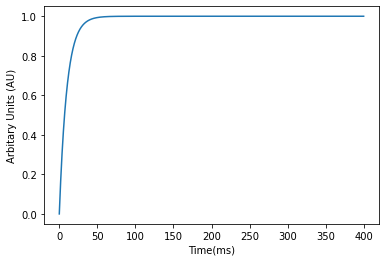

In [62]:
run(100*ms);

plot(v_mon.t/ms,v_mon.v[0]);
xlabel('Time(ms)');
ylabel('Arbitary Units (AU)');

We have now conducted our first neuron simulation using Brian 2! However, we now have to consider how to model the behavior of actual neurons. 

## Spiking Models
From simple biological observations, we know that neurons function through the use of action potentials. The voltage in a neuron increases until it hits a threshold, where it fires and action potential before its voltage decreases. We can implement this into our previous model using the following code

In [17]:
start_scope();

tau = 10*ms;

eq = '''
dv/dt = (1-v)/tau : 1
'''

single_neuron = NeuronGroup(1, eq, threshold='v>0.75', reset='v=0', method=euler);

v_mon = StateMonitor(single_neuron, 'v', record=True);
s_mon = SpikeMonitor(single_neuron);

In the above code, we can see that two new parameters have been added to ``NeuronGroup``. ``threshold`` allows us to specify the threshold value for an action potential. After reaching this value, the neuron resets to the value specified by ``reset``. 

We've also added a new kind of monitor, known as a ``SpikeMonitor``. This will allow us to watch a ``NeuronGroup``, and record the time at which spikes occur.

Using these new parameters, we now have a very basic spiking neuron model!

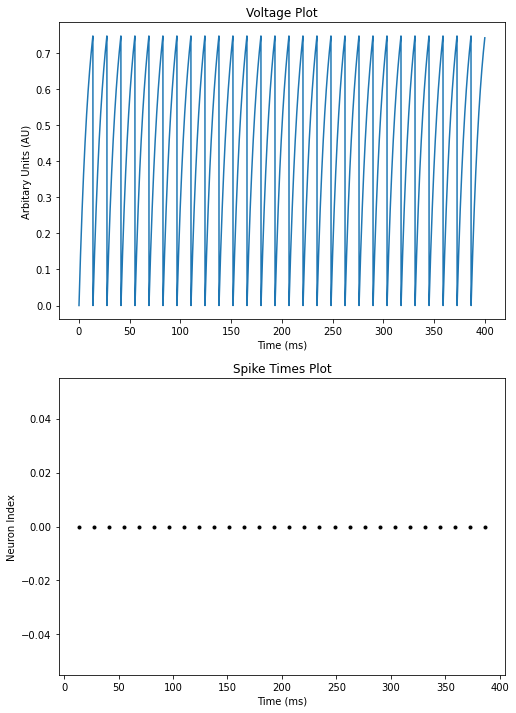

In [21]:
run(100*ms);

# Changing figure size for clarity
plt.figure(figsize=(8, 12))

subplot(211)
plot(v_mon.t/ms,v_mon.v[0]);
title('Voltage Plot');
xlabel('Time (ms)');
ylabel('Arbitary Units (AU)');

subplot(212)
plot(s_mon.t/ms, s_mon.i, '.k');
title('Spike Times Plot');
xlabel('Time (ms)');
ylabel('Neuron Index');

We should now consider how we can create a network neurons that interact with each other. To do this, we will be using ``Synapses``.

In [77]:
start_scope();


eq = '''
dv/dt = (v0-v)/tau : 1
v0 : 1
'''

neurons = NeuronGroup(2, eq, threshold='v>0.75', reset='v=0', method=euler);
neurons.v0 = [2, 1];

S = Synapses(neurons, neurons, on_pre='v_post += 0.1');
S.connect(i=0, j=1);

v_mon = StateMonitor(neurons, 'v', record=True);

Above, we have made a few changes to our neuron. We have now added a new constant to the equation, ``v0``, which represents the value that our differential equation moves towards. This value can be set for each neuron, as shown in line 11. 

Next, we use the ``Synapses`` function to connect our neruons. The first two inputs represent the pre-synaptic ``NeuronGroup`` and the post-synaptic ``NeuronGroup``, respectively. Because both of of our neurons are in the same group, we can connect ``neurons`` to ``neurons``.

The parameter ``on_pre='v_post += 0.2'`` describes what happens to a post-synaptic neuron when a pre-synaptic neuron fires. When the pre-synaptic neuron reaches threshold (``on_pre``), the value of ``v`` in the post-synaptic neuron (``_post``) increases by a value of 0.2.

Finally, we can connect the first neuron (index of 0) in the ``NeuronGroup`` to the second (index of 1), using ``S.connect(i=0, j=1)``, where ``i`` is the pre-synaptic neuron and ``j`` is the post-synaptic neuron.

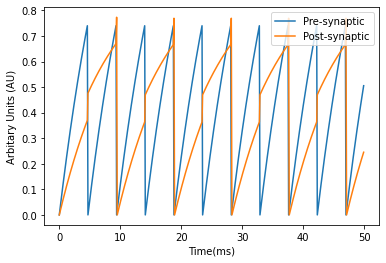

In [78]:
run(50*ms);

plot(v_mon.t/ms,v_mon.v[0], label = 'Pre-synaptic');
plot(v_mon.t/ms,v_mon.v[1], label = 'Post-synaptic');
legend();
xlabel('Time (ms)');
ylabel('Arbitary Units (AU)');

Running this simulation, we can see how the pre-synaptic neuron causes the post-synaptic neuron's ``v`` value to increase each time it fires. Now, we have finally created a spiking neuron network!